In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!unzip "/content/drive/MyDrive/archive.zip" -d "/content/"

Archive:  /content/drive/MyDrive/archive.zip
replace /content/BBC News Summary/News Articles/business/001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [15]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

data_path = "/content/BBC News Summary/News Articles"

In [16]:
import os
texts = []
labels = []

for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            with open(file_path, 'r', encoding='latin-1') as f:
                texts.append(f.read())
                labels.append(category)

# Создаём DataFrame
data = pd.DataFrame({'text': texts, 'label': labels})
print(data)

                                                   text     label
0     McConnell details Scots wave toll\n\nAt least ...  politics
1     UK needs tax cuts, Tories insist\n\nA major ch...  politics
2     Terror detainees win Lords appeal\n\nDetaining...  politics
3     Tories attack EU asylum moves\n\nDavid Blunket...  politics
4     Blair rejects Tory terror offer\n\nTony Blair ...  politics
...                                                 ...       ...
2220  Video phones act as dating tools\n\nTechnologi...      tech
2221  Man auctions ad space on forehead\n\nA 20-year...      tech
2222  Apple makes blogs reveal sources\n\nApple has ...      tech
2223  Cyber criminals step up the pace\n\nSo-called ...      tech
2224  Rings of steel combat net attacks\n\nGambling ...      tech

[2225 rows x 2 columns]


In [17]:
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Удаляем всё, кроме букв
    text = text.lower()                      # В нижний регистр
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

data['cleaned_text'] = data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


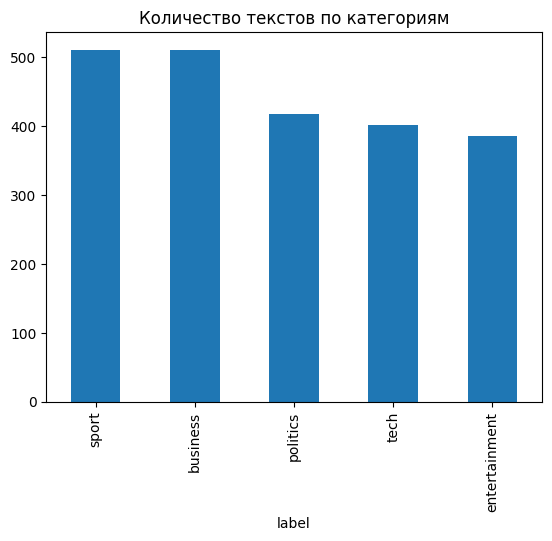

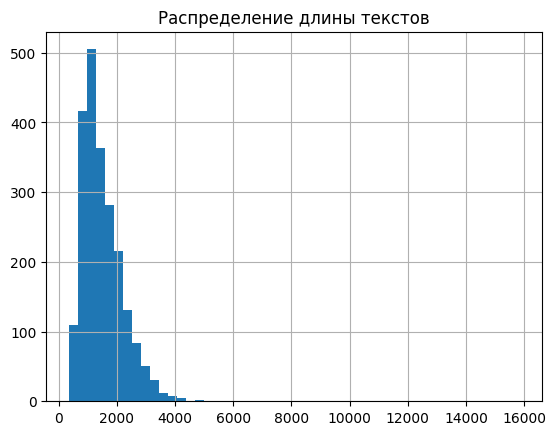

In [18]:
# Распределение категорий
data['label'].value_counts().plot(kind='bar')
plt.title('Количество текстов по категориям')
plt.show()

# Длина текстов после очистки
data['text_length'] = data['cleaned_text'].apply(len)
data['text_length'].hist(bins=50)
plt.title('Распределение длины текстов')
plt.show()

In [19]:
tfidf = TfidfVectorizer(max_features=5000)  # Ограничим размерность
X = tfidf.fit_transform(data['cleaned_text'])
y = data['label'].factorize()[0]  # Преобразуем метки в числа (0, 1, 2...)

In [20]:
kmeans = KMeans(n_clusters=5, random_state=42)  # 5 кластеров = 5 категорий
clusters = kmeans.fit_predict(X)

# Оценка
ari = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index: {ari:.2f}")  # Идеально = 1.0, случайно = 0.0

Adjusted Rand Index: 0.71


Судя по данным кластеры достаточно хорошо соответсвуют реальным категориям

Adjusted Rand Index: 0.71


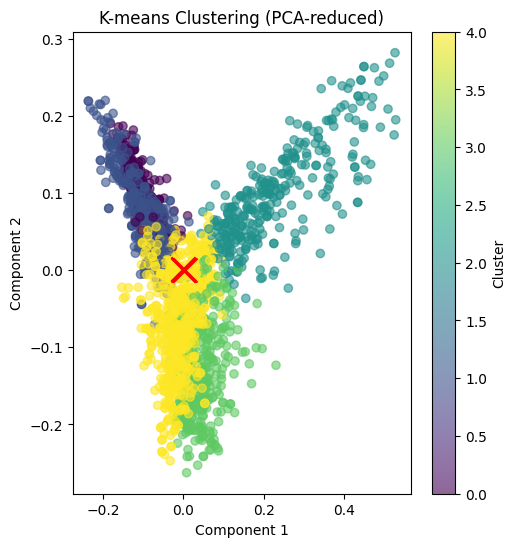

In [21]:

# Предполагаем, что X - ваш набор данных, y - истинные метки
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

# Оценка
ari = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index: {ari:.2f}")

# Визуализация
plt.figure(figsize=(12, 6))

# Если данные многомерные (больше 2 признаков), используем PCA для уменьшения размерности
if X.shape[1] > 2:
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    title_suffix = " (PCA-reduced)"
else:
    X_reduced = X
    title_suffix = ""

# Визуализация кластеров
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title(f'K-means Clustering{title_suffix}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label='Cluster')



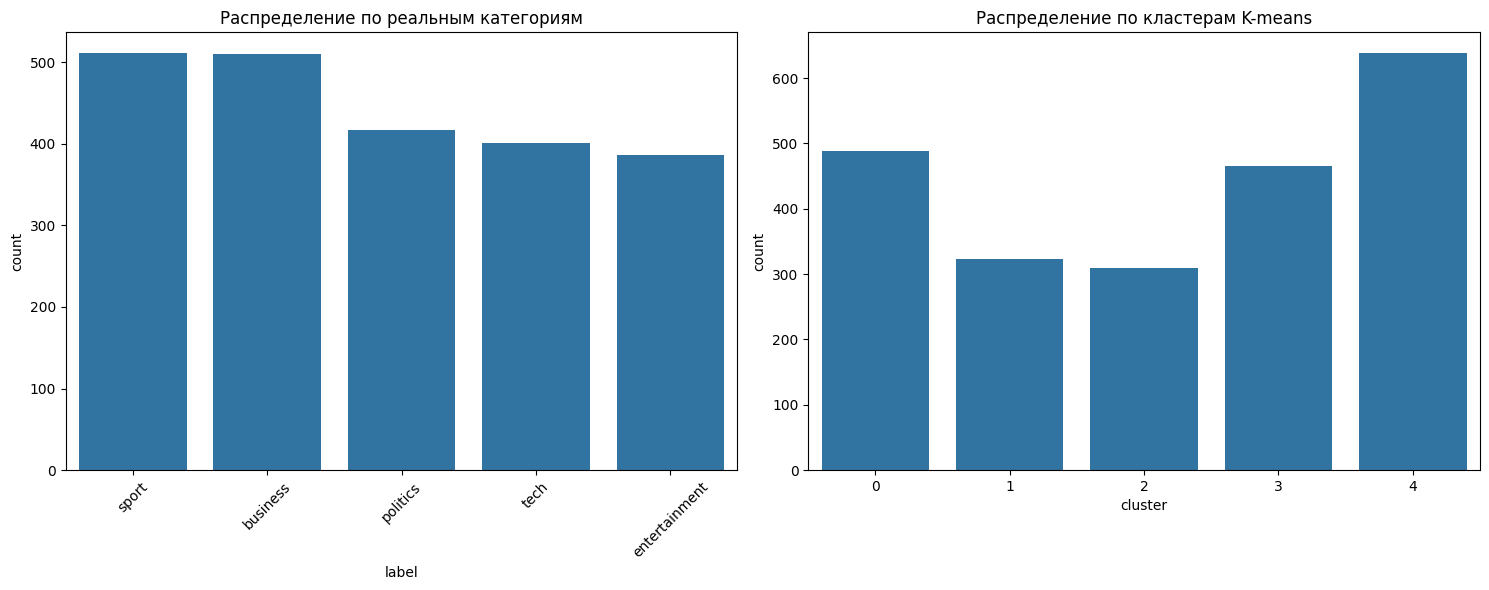

In [22]:


# Создаём DataFrame с реальными метками и кластерами
results = data.copy()
results['cluster'] = clusters

# Распределение по реальным категориям
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=results, x='label', order=results['label'].value_counts().index)
plt.title('Распределение по реальным категориям')
plt.xticks(rotation=45)

# Распределение по кластерам K-means
plt.subplot(1, 2, 2)
sns.countplot(data=results, x='cluster')
plt.title('Распределение по кластерам K-means')

plt.tight_layout()
plt.show()

In [23]:


# Сначала на train+val и test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Затем на train и val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 1607, Val: 284, Test: 334
